# 📊 KMA 공공 데이터 2: 데이터 분석

## 📝 서론
이 노트북은 한국 기상청(KMA) 공공 데이터(https://apihub.kma.go.kr/)에서 수집한 날씨 관련 데이터 분석을 계속하기 위해 설계되었습니다. 이전 세션에서는 두 가지 유형의 관측이 가능한 위치에서 온도 및 황사 데이터를 다운로드했습니다.

📌 **오늘의 목표**  
이번 세션에서는:

같은 관측 지점에서 습도 데이터를 추가합니다.
온도, 습도 및 황사 발생 간의 관계를 분석합니다.
우리는 온도와 습도와 같은 대기 조건이 황사 사건의 존재 또는 강도와 어떤 관련이 있는지를 탐구하는 것을 목표로 합니다.

---
## 🌡️💧🌫️ 기상 조건과 황사 분석
기상 조건(온도와 습도)과 황사 사건 간의 관계를 분석합니다.

- **핵심 질문**:  
  온도와 습도가 황사 사건의 발생 또는 강도에 영향을 미치는가?

- 단계:
  - 상관 계수 계산
  - 시계열 비교 시각화
  - 변수 상호작용 분석

---


# ⚙️ **1. 설정**

In [1]:
# modules
import pandas as pd
import requests

import matplotlib.pyplot as plt

In [2]:
# Mount google drive and check the directory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 📥 **2. 데이터 준비**

이 단계에서는 우리의 분석에 필요한 기상 데이터를 준비합니다.

우리의 목표는 같은 관측 지점과 시간(2024년 4월, 108번 기상 관측소)의 온도와 습도 데이터를 단일 일일 수준의 테이블로 결합하는 것입니다.

- 온도 데이터는 이전 세션에서 이미 수집되었습니다. 저장된 CSV 파일에서 이를 간단히 로드합니다.
- 습도 데이터는 아래 작업의 일환으로 오늘 다운로드 될 것입니다.
- 두 데이터 세트는 병합하기 전에 일일 평균으로 변환해야 합니다.

---

🚀 **작업:**  
KMA 공공 데이터 URL을 사용하여 2024년 4월 동안 108번 기상 관측소의 시간별 습도 데이터를 다운로드하고 CSV 파일로 저장하세요.

그런 다음 온도와 습도 데이터를 처리하여 일일 평균 값을 생성합니다.

💡 **힌트:**
- KMA 공공 데이터 포털(https://apihub.kma.go.kr/) 에서 지상관측 > 종관기상관측 > 요소별 조회의 습도 데이터를 찾으세요.
- 이전 노트북의 download_kma_data() 함수를 재사용하세요.
- 108번 기상 관측소와 올바른 날짜 범위의 습도 데이터를 요청하도록 매개변수를 수정하세요.
- 시간별 데이터를 일일 평균으로 변환하려면 .resample('D').mean()을 사용하세요.
- 추천 열 구조: ['STN', 'LON', 'LAT', 'HT', 'HUMIDITY']


In [3]:
def download_kma_data(url, fpath):
    """
    주어진 KMA URL에서 데이터를 다운로드하고, 지정된 파일 경로에 저장하는 함수입니다.

    매개변수:
    - url (str): 데이터를 가져올 URL.
    - fpath (str): 다운로드한 데이터를 저장할 파일 경로.

    반환값:
    - 없음
    """
    try:
        # URL로 GET 요청을 보냅니다.
        response = requests.get(url)

        # 요청이 성공적인지 확인합니다. (HTTP 상태 코드 200은 성공을 의미)
        if response.status_code == 200:
            # 성공하면 파일을 로컬에 저장합니다.
            with open(fpath, 'wb') as file:  # 'wb'는 바이너리 형식으로 파일을 열기 위함
                file.write(response.content)  # 받은 데이터를 파일에 씁니다.
            print(f"다운로드가 성공적으로 완료되었습니다! 저장 위치: {fpath}")
        else:
            # 요청이 실패한 경우 상태 코드와 함께 에러 메시지를 출력합니다.
            print(f"파일 다운로드 실패. 상태 코드: {response.status_code}")

    except Exception as e:
        # 예외가 발생한 경우 에러 메시지를 출력합니다.
        print(f"오류가 발생했습니다: {e}")


In [4]:
# 2024년 4월의 습도 데이터를 https://apihub.kma.go.kr 에서 가져온다
# 주의!!! 아래 링크는 "기온(temperature)"용이므로 "습도(humidity)"용으로 바꿔야 한다!!!
#obs=TA -> obs=HM (데이터변환 : 기온 -> 습도)
#stn=0 -> stn=108 (108번 관측소를 가져오라고 했으니까)
url='https://apihub.kma.go.kr/api/typ01/url/kma_sfctm5.php?tm1=202404010000&tm2=202404302359&obs=HM&stn=108&disp=0&help=1&authKey=dsi6kOLASrGIupDiwPqxYA'
fpath1 = '/content/drive/MyDrive/Weather_BigData/kma_humid_202404.csv'

#습도 데이터 다운 (fpath1)
download_kma_data(url, fpath1)

다운로드가 성공적으로 완료되었습니다! 저장 위치: /content/drive/MyDrive/Weather_BigData/kma_humid_202404.csv


In [8]:
#기온데이터 가져오기 (수집에서 쓴 )
df_temp = pd.read_csv('/content/drive/MyDrive/Weather_BigData/kma_temp_202404.csv',
                      encoding='euc-kr', #한글 패치
                      comment='#', # #로 시작하는 줄은 무시
                      sep=r'\s+',  # 공백(스페이스, 탭 등)으로 구분된 데이터
                      header=None,#원본 파일에 열 이름이 없음
                      index_col=0,#첫번째 열을 인덱스로 사용
                      parse_dates=True, #날짜 자동 인식
                      names= ['STN','LON','LAT','HT','TEMP'], #열 이름 직접 지정
                      on_bad_lines='skip' # 에러난 라인 스킵해
                     )

#5. 습도 데이터 가져오기
df_humid = pd.read_csv(fpath1,
                      encoding='euc-kr', #한글 패치
                      comment='#', # #로 시작하는 줄은 무시
                      sep=r'\s+',  # 공백(스페이스, 탭 등)으로 구분된 데이터
                      header=None,#원본 파일에 열 이름이 없음
                      index_col=0,#첫번째 열을 인덱스로 사용
                      parse_dates=True, #날짜 자동 인식
                      names= ['STN','LON','LAT','HT','HUMIDITY'], #열 이름 직접 지정
                      on_bad_lines='skip' # 에러난 라인 스킵해
                     )
# print(df_humid.head(5))
print(df_humid.describe()) #숫자형 데이터 요약 통계 출력

         STN           LON           LAT            HT    HUMIDITY
count  720.0  7.200000e+02  7.200000e+02  7.200000e+02  720.000000
mean   108.0  1.269658e+02  3.757142e+01  8.567000e+01   56.187500
std      0.0  1.151879e-12  1.919799e-13  1.265645e-12   18.694517
min    108.0  1.269658e+02  3.757142e+01  8.567000e+01   16.000000
25%    108.0  1.269658e+02  3.757142e+01  8.567000e+01   43.000000
50%    108.0  1.269658e+02  3.757142e+01  8.567000e+01   55.000000
75%    108.0  1.269658e+02  3.757142e+01  8.567000e+01   69.250000
max    108.0  1.269658e+02  3.757142e+01  8.567000e+01   96.000000


In [9]:
df_meteo=pd.concat([df_temp,df_humid],axis=1) #열로 합치기 (옆으로 추가)
df_meteo=df_meteo[['TEMP', 'HUMIDITY']].copy() #온도 습도 컬럼만
print(df_meteo[:5])
print(df_meteo.describe())

                     TEMP  HUMIDITY
2024-04-01 00:00:00   9.5        50
2024-04-01 01:00:00   8.6        53
2024-04-01 02:00:00   7.7        53
2024-04-01 03:00:00   7.2        54
2024-04-01 04:00:00   6.7        56
             TEMP    HUMIDITY
count  720.000000  720.000000
mean    16.301944   56.187500
std      4.416507   18.694517
min      5.700000   16.000000
25%     12.900000   43.000000
50%     16.000000   55.000000
75%     19.200000   69.250000
max     28.900000   96.000000


In [10]:
#시간 데이터를 일 평균으로 묶기 (하루 24개 데이터 평균냄)
#2024-04-01 00:00:00 -> 2024-04-01
daily_meteo=df_meteo.resample('D').mean()
print(daily_meteo[:5])

                 TEMP   HUMIDITY
2024-04-01  12.012500  34.208333
2024-04-02  14.900000  36.250000
2024-04-03  16.491667  52.875000
2024-04-04  15.695833  53.416667
2024-04-05  14.200000  50.250000


# 📝 **연습 작업 3: 황사 관측 데이터 준비**

이번 세션에서는 분석을 위한 황사(황사) 데이터를 준비합니다.

이 데이터 세트는 이전 세션에서 이미 다운로드했습니다. 이제 여러분은:

- 황사 관측 데이터(CSV에서) 로드하기.
- 열, 유형 및 품질 플래그를 이해하기 위해 데이터 구조를 확인하기.
기본 탐색적 데이터 분석(EDA) 수행하기:
- 누락된 값 식별하기. 트렌드와 변동성을 탐색하기 위한 간단한 시각화 만들기.

---

🔍 **필터링 및 집계 작업:**

- 품질 플래그(FLAG)가 0인 행만 유지합니다.
- 날짜별로 데이터를 그룹화하고 일일 평균 황사 수준을 계산합니다.
- 데이터가 90% 이상(≥ 22시간 기록)을 포함하는 날만 포함합니다.

이미 연습한 데이터 처리 기술을 사용하여 황사 데이터를 효과적으로 정리하고 요약하세요. 📊

In [11]:
#황사 데이터
fpath2 = '/content/drive/MyDrive/Weather_BigData/kma_pm10_202404.csv'
df_pm = pd.read_csv(fpath2,
                    encoding='euc-kr',#한글 패치
                    comment='#', # #로 시작하는 줄은 무시
                    sep=',',  # 쉼표로 구분된 데이터
                    header=None, #원본 파일에 열 이름이 없음
                    index_col=0, #첫번째 열을 인덱스로 사용
                    parse_dates=True, #날짜 자동 인식
                    names=["STN","PM10","FLAG","MQC",'DUM'], #열 이름 직접 지정
                    on_bad_lines='skip' #에러난 라인 스킵
                   )
#품질플래그(FLAG)가 0인 행만 유지
df_pm=df_pm[df_pm['FLAG']==0].copy()

In [12]:
# Display the DataFrame
# print(df_pm[:5])
# print(df_pm.describe())

print(df_pm['PM10'].groupby(df_pm.index.date).count()) #날짜 별로 묶기

2024-04-01    287
2024-04-02    230
2024-04-03    287
2024-04-04    287
2024-04-05    287
2024-04-06    257
2024-04-07    178
2024-04-08    286
2024-04-09    287
2024-04-10    287
2024-04-11    287
2024-04-12    287
2024-04-13    287
2024-04-14    287
2024-04-15    287
2024-04-16    286
2024-04-17    284
2024-04-18    283
2024-04-19    285
2024-04-20    286
2024-04-21    287
2024-04-22    287
2024-04-23    287
2024-04-24    287
2024-04-25    287
2024-04-26    284
2024-04-27    286
2024-04-28    287
2024-04-29    287
2024-04-30    284
2024-05-01    287
Name: PM10, dtype: int64


In [13]:
#데이터가 전체의 90퍼만 있어도 ㄱㅊ
df_pm_selected = df_pm.groupby(df_pm.index.date).filter(lambda x: len(x) >= 12*24*0.9)
#하루 데이터x개수를 세서 12*24*0.9 = 259.2 → 260개 이상이면 통과
#하루치가 대략 5분 간격 측정 => 1시간에 12개 × 24시간)
daily_pm = df_pm_selected[['PM10']].resample('D').mean()
#시간 데이터를 일 평균으로 묶기 (하루 260개 데이터를 평균냄)
print(daily_pm[:10])

                 PM10
2024-04-01  46.010453
2024-04-02        NaN
2024-04-03  35.926829
2024-04-04  33.644599
2024-04-05  43.707317
2024-04-06        NaN
2024-04-07        NaN
2024-04-08  49.916084
2024-04-09  43.864111
2024-04-10  42.055749


# 🔎 **4. 데이터 비교 및 상관 분석**

이 섹션에서는 온도, 습도 및 황사(PM10) 데이터를 비교하여 이들 간의 가능한 관계를 탐구합니다.

---

🚀 **작업:**

- 일일 수준의 온도, 습도 및 황사 데이터 세트를 날짜를 키로 하여 단일 DataFrame으로 병합합니다.
- 세 변수가 시간에 따라 어떻게 변화하는지 비교하기 위해 시계열 플롯을 생성합니다.
- 다음 두 가지 산점도를 시각화합니다:
  - 온도 vs. PM10
  - 습도 vs. PM10
- 변수 간의 상관 계수를 계산합니다.
- 결과를 해석합니다: 눈에 띄는 패턴이나 연관성이 있습니까?
merge(), scatter() 및 .corr()에 대한 이전 경험을 사용하여 분석을 수행하세요.


In [14]:
#concat two data
df=pd.concat([daily_meteo, daily_pm],axis=1) #열로 합치기 (옆으로 추가)
df = df.dropna() #결측치 줄 삭제 (실행해보면 27 -> 3일치 잃어버림)
print(df.describe())

            TEMP   HUMIDITY        PM10
count  27.000000  27.000000   27.000000
mean   16.553086  57.921296   52.920681
std     2.307849  12.137728   32.912882
min    12.012500  34.208333   11.919861
25%    15.012500  50.958333   34.785714
50%    16.520833  54.791667   44.324042
75%    17.945833  64.645833   54.038876
max    20.912500  82.791667  151.496479


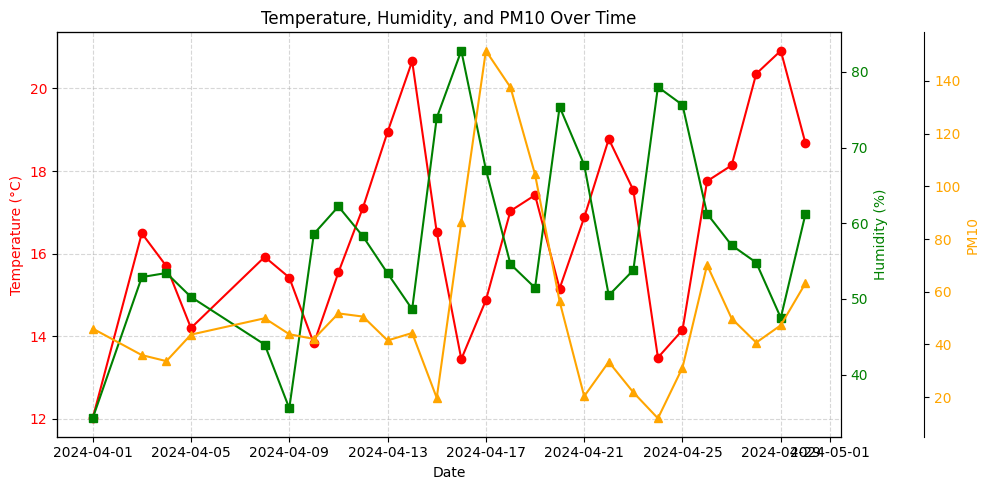

In [18]:
# 그래프 창 만들기 (가로 10인치, 세로 5인치)
fig, ax1 = plt.subplots(figsize=(10, 5))

# 온도 데이터 선 그래프로 그리기 (빨간색 원 마커)
ax1.plot(df.index, df["TEMP"], color="red", marker="o", linestyle="-", label="Temperature (°C)")
ax1.set_xlabel("Date")  # x축 라벨
ax1.set_ylabel("Temperature (°C)", color="red")  # 왼쪽 y축 라벨
ax1.tick_params(axis="y", labelcolor="red")  # 왼쪽 y축 글씨 색
ax1.grid(True, linestyle="--", alpha=0.5)  # 격자선 (점선, 반투명)

# 두 번째 y축 (오른쪽) 생성해서 습도 그리기
ax2 = ax1.twinx()
ax2.plot(df.index, df["HUMIDITY"], color="green", marker="s", linestyle="-", label="Humidity (%)")
ax2.set_ylabel("Humidity (%)", color="green")  # 오른쪽 y축 라벨
ax2.tick_params(axis="y", labelcolor="green")  # 오른쪽 y축 글씨 색

# 세 번째 y축 생성해서 PM10 표시 (조금 더 오른쪽으로 밀기)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # 세 번째 y축을 오른쪽으로 60만큼 이동
ax3.plot(df.index, df["PM10"], color="orange", marker="^", linestyle="-", label="PM10")
ax3.set_ylabel("PM10", color="orange")  # 세 번째 y축 라벨
ax3.tick_params(axis="y", labelcolor="orange")  # 세 번째 y축 글씨 색

# 제목 설정 + 레이아웃 자동 정리
plt.title("Temperature, Humidity, and PM10 Over Time")
fig.tight_layout()
plt.show()  # 그래프 출력


In [ ]:
#시간별 데이터로 테스트하기
# daily_meteo=df_meteo.copy()
# daily_pm = df_pm_selected[['PM10']].resample('h').mean()
# df=pd.concat([daily_meteo, daily_pm],axis=1)
# df = df.dropna()

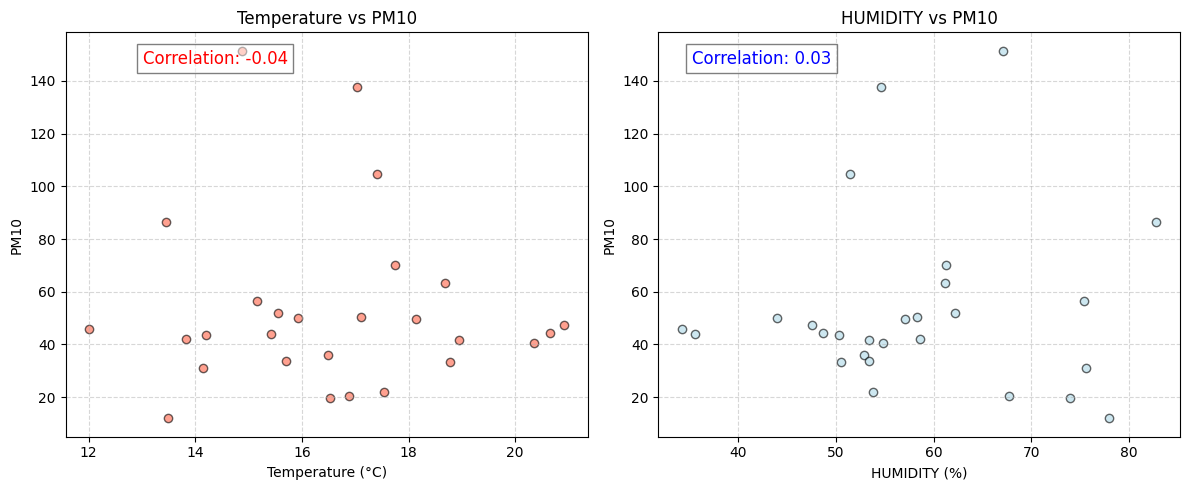

In [19]:
# 1행 2열로 subplot(그래프 창) 만들기
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- 1. 온도 vs 미세먼지 PM10 산점도 ---
axes[0].scatter(df["TEMP"], df["PM10"], color="tomato", alpha=0.6, edgecolors="black")  # 산점도 그리기
corr_temp = df["TEMP"].corr(df["PM10"])  # 온도와 PM10의 상관계수 계산
axes[0].set_xlabel("Temperature (°C)")  # x축 이름
axes[0].set_ylabel("PM10")              # y축 이름
axes[0].set_title("Temperature vs PM10")  # 그래프 제목
axes[0].grid(True, linestyle="--", alpha=0.5)  # 격자선 표시

# 상관계수 텍스트로 그래프 안에 표시
axes[0].text(
    x=min(df["TEMP"]) + 1,
    y=max(df["PM10"]) - 5,
    s=f"Correlation: {corr_temp:.2f}",  # 소수점 2자리까지 표시
    fontsize=12,
    color="red",
    bbox=dict(facecolor="white", alpha=0.5, edgecolor="black")  # 흰 배경 박스
)

# --- 2. 습도 vs 미세먼지 PM10 산점도 ---
axes[1].scatter(df["HUMIDITY"], df["PM10"], color="lightblue", alpha=0.6, edgecolors="black")  # 산점도
corr_mumidity = df["HUMIDITY"].corr(df["PM10"])  # 습도와 PM10 상관계수
axes[1].set_xlabel("HUMIDITY (%)")  # x축 이름
axes[1].set_ylabel("PM10")          # y축 이름
axes[1].set_title("HUMIDITY vs PM10")  # 제목
axes[1].grid(True, linestyle="--", alpha=0.5)  # 격자선

# 상관계수 텍스트로 표시
axes[1].text(
    x=min(df["HUMIDITY"]) + 1,
    y=max(df["PM10"]) - 5,
    s=f"Correlation: {corr_mumidity:.2f}",
    fontsize=12,
    color="blue",
    bbox=dict(facecolor="white", alpha=0.5, edgecolor="black")
)

plt.tight_layout() # 그래프 간격 자동 조정
plt.show() # 그래프 표시


### ⚠️ 개별 상관 분석의 한계

- 온도와 습도와 같은 각 변수를 별도로 분석하면 다른 변수의 영향을 무시하게 되어 과도하게 단순화된 해석을 초래합니다.
- 실제 환경 데이터에 존재할 수 있는 상호 작용이나 다변량 효과를 포착하지 못합니다.

---

### 🤔 온도와 습도가 PM10과 이렇게 관계가 있을 수 있는 이유는 무엇일까요?
